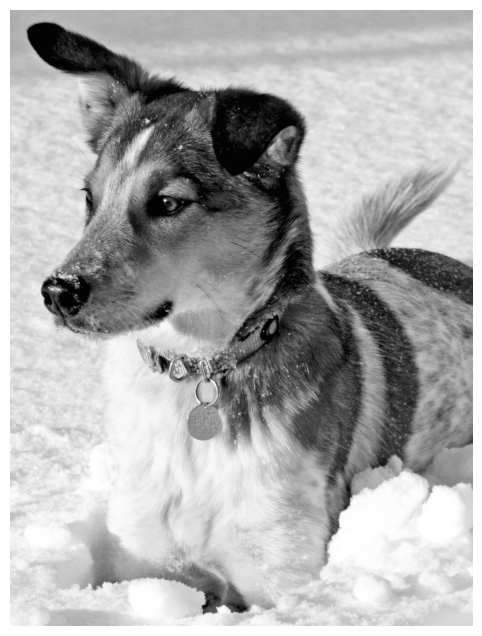

In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
plt.rcParams['figure.figsize'] = [16, 8]


A = imread(os.path.join('DATA','dog.jpg'),)
X = np.mean(A, 2); # Convert RGB to grayscale
img = plt.imshow(X)
img.set_cmap('gray')
plt.axis('off')
plt.show()

In [2]:
X.shape

(2000, 1500)

In [3]:
class SVD:
    def __init__(self, matrix, method='power', rank=None, full_matrices=True, max_iteration=1000, tol=1e-16):
        self.matrix = matrix
        self.method = method
        self.rank = rank
        self.full_matrices = full_matrices
        self.max_iteration = max_iteration
        self.tol = tol
        self.eigenvalues = None
        self.eigenvectors = None
        self.singular_values = None
        
    def _power_iteration(self):
        matrix = self.matrix.T @ self.matrix
        m, n = matrix.shape
        r = 0
        eigenvalues, eigenvectors = [], []
        
        if self.rank is not None and self.rank > m:
            self.rank = m
            warnings.warn('The rank of the matrix is greater than the number of rows. The rank is set to the number of rows.')
        if self.rank is None:
            self.rank = m
            warnings.warn('The rank of the matrix is not specified. The rank is set to the number of rows.')
       
        while r < self.rank:
            e_prev = 0
            v = np.ones(m)
            x = np.dot(matrix,v)
            
            for _ in range(self.max_iteration):
                v = x / np.linalg.norm(x)
                e = np.dot(x.T,v)
                x = np.dot(matrix, v)
                
                if np.linalg.norm(e - e_prev) < self.tol:
                    break
                e_prev = e
                
            eigenvalues.append(e)
            eigenvectors.append(v)
            
            matrix = matrix - e * np.outer(v, v)
            r += 1
            
        return np.array(eigenvalues), np.array(eigenvectors).T
    
    def _qr_method(self, matrix):
        m, n = matrix.shape
        Q = np.zeros((m,n))
        R = np.zeros((n,n))

        for j in range(n):
            v = matrix[:,j]
            for i in range(j):
                R[i,j] = np.dot(Q[:,i], matrix[:,j])
                v = v - R[i,j]* Q[:,i]
            R[j,j] = np.linalg.norm(v)
            Q[:,j] = v / R[j,j]
        return Q, R
    
    def _decompose(self):
        if self.method == 'power':
            self.eigenvalues, self.eigenvectors = self._power_iteration()
            self.singular_values = np.sqrt(np.maximum(self.eigenvalues, 0))
            U = self.matrix @ self.eigenvectors / self.singular_values
        
            nonzero_indices = np.where(self.singular_values > 1e-5)[0]
            self.singular_values = self.singular_values[nonzero_indices]
            U = U[:, nonzero_indices]
        
            if not self.full_matrices:
                VT = self.eigenvectors.T[nonzero_indices, :]
            else:
                VT = self.eigenvectors.T
            
            self.U, self.V = U, VT
        
        elif self.method == 'qr':
            B = self.matrix.T@self.matrix
            m, n = B.shape
            U = np.eye(m)
            V = np.eye(n)
            
            for _ in range(self.max_iteration):
                Q, R = self._qr_method(B)
                B= np.dot(R, Q)
                U = np.dot(U, Q)
                V = np.dot(V, Q.T)
                
                norm = np.linalg.norm(B - np.diag(np.diag(B)))
                if norm < self.tol:
                    break
                    
            self.singular_values = np.sqrt(np.diag(B))
            self.U, self.V = U, V.T

In [4]:
matrix = np.array([[0,2],[2,3]])

In [5]:
svd = SVD(matrix)
svd._decompose()
svd.U@np.diag(svd.singular_values)@svd.V

/var/folders/99/qthrvdvx6k93mymnrzdj9xbw0000gn/T/ipykernel_45510/3206126529.py:24: UserWarning: The rank of the matrix is not specified. The rank is set to the number of rows.
  warnings.warn('The rank of the matrix is not specified. The rank is set to the number of rows.')


array([[-8.7312189e-11,  2.0000000e+00],
       [ 2.0000000e+00,  3.0000000e+00]])

In [6]:
matrix = np.array([[0,2],[2,3]])
np.linalg.svd(matrix)

SVDResult(U=array([[-0.4472136 , -0.89442719],
       [-0.89442719,  0.4472136 ]]), S=array([4., 1.]), Vh=array([[-0.4472136 , -0.89442719],
       [ 0.89442719, -0.4472136 ]]))

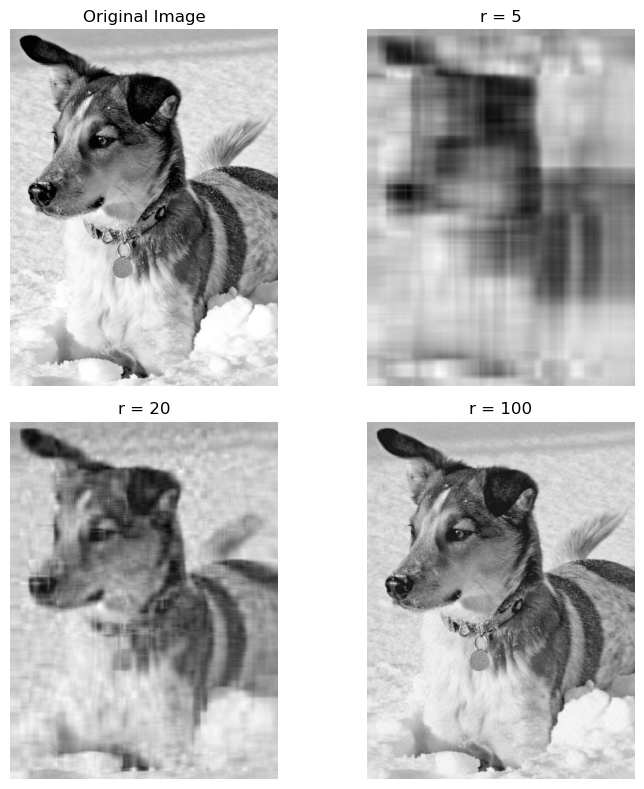

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].imshow(X, cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].set_title('Original Image')

j = 1
for r in (5, 20, 100):
    svd = SVD(X, rank=r)
    svd._decompose()
    
    Xapprox = svd.U[:, :r] @ np.diag(svd.singular_values)[:r, :r] @ svd.V[:r, :]
    
    row = j // 2
    col = j % 2
    axs[row, col].imshow(Xapprox, cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title('r = ' + str(r))
    
    j += 1

plt.tight_layout()

fig.savefig('image_approx.jpg')
plt.show()
